In [1]:
import os
import numpy as np
import matplotlib as mpt
import matplotlib.pyplot as plt
import open3d as o3d
import open3d.t.pipelines.registration as treg
from tqdm.notebook import tqdm
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
from scipy.spatial.transform import Rotation
import time
import copy

In [3]:
import torch
import MinkowskiEngine as ME

## Вспомогательные функции

In [4]:
def visualize_pcd(ref_cloud):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(ref_cloud[:, :3])
    pcd.colors = o3d.utility.Vector3dVector(ref_cloud[:, 3:] / 255)

    o3d.visualization.draw_plotly([pcd], width=800, height=600)


def draw_registration_result(source, target, transformation, title=None):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])

    source_temp.transform(transformation)

    if title is not None:
        print(title)

    o3d.visualization.draw_plotly([source_temp, target_temp])


def compare_grids(grid1, grid2, label1='Current grid', label2='Reference grid'):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    cmap = mpt.colors.ListedColormap(['white', 'gray', 'black'])

    axs[0].imshow(grid1, cmap=cmap)
    axs[0].set_title(label1)
    axs[0].grid(True, alpha=0.5, linestyle='-')

    axs[1].imshow(grid2, cmap=cmap)
    axs[1].set_title(label2)
    axs[1].grid(True, alpha=0.5, linestyle='-')

    fig.tight_layout()
    fig.show()


def visualize_iou(aligned_grid):
    plt.imshow(aligned_grid)
    plt.axis(False)
    plt.grid(True, alpha=0.5, linestyle='-')

    plt.show()


def make_pcd_from_array(array):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(array)

    return pcd

## Регистрация облаков точек

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
preprocess_time = []
registration_time = []
transform_time = []

In [7]:
def remove_floor_and_ceil(cloud, floor_height=-0.9, ceil_height=1.5):
    heights = np.linspace(-4.0, 4.0, 41)
    floor_index = None
    if floor_height == 'auto':
        bins = []
        for i, height in enumerate(heights[:-1]):
            bins.append(len(cloud[(cloud[:, 2] > height) * (cloud[:, 2] < heights[i + 1])]))
        #print('Bins:', bins)
        floor_index = np.argmax(bins[:20]) + 1
        floor_height = heights[floor_index]
        assert floor_index < len(heights) - 5
    if ceil_height == 'auto':
        if floor_index is None:
            floor_index = 0
            while floor_index < len(heights) - 6 and heights[floor_index] < floor_height:
                floor_index += 1
        ceil_index = floor_index + 5 + np.argmax(bins[floor_index + 5:])
        ceil_height = heights[ceil_index]
    #print('Floor height:', floor_height)
    #print('Ceil height:', ceil_height)
    return cloud[(cloud[:, 2] > floor_height) * (cloud[:, 2] < ceil_height)]

In [8]:
def raycast(grid, n_rays=1000, center_point=None):
    grid_raycasted = grid.copy()
    if center_point is None:
        center_point = (grid.shape[0] // 2, grid.shape[1] // 2)
    resolution = 0.1
    radius = 8.0 / resolution
    for sector in range(n_rays):
        angle = sector / n_rays * 2 * np.pi - np.pi
        ii = center_point[0] + np.sin(angle) * np.arange(0, radius)
        jj = center_point[1] + np.cos(angle) * np.arange(0, radius)
        ii = ii.astype(int)
        jj = jj.astype(int)
        good_ids = ((ii > 0) * (ii < grid.shape[0]) ** (jj > 0) * (jj < grid.shape[1])).astype(bool)
        ii = ii[good_ids]
        jj = jj[good_ids]
        points_on_ray = grid[ii, jj]
        if len(points_on_ray.nonzero()[0]) > 0:
            last_obst = points_on_ray.nonzero()[0][-1]
            grid_raycasted[ii[:last_obst], jj[:last_obst]] = 1
        #else:
            #grid_raycasted[ii, jj] = 1
    return grid_raycasted

In [9]:
from scipy.ndimage import affine_transform

def transform_grid(grid, x, y, theta):
    shift_vector = np.array([x, y])
    rotation_matrix = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])

    center = np.array(grid.shape) / 2
    offset = center - rotation_matrix @ center
    offset += shift_vector

    grid_transformed = np.zeros(grid.size).reshape(grid.shape)
    grid_transformed = affine_transform(grid, rotation_matrix, offset=offset, order=0, mode='constant', cval=0)
    grid_transformed = grid_transformed.astype(np.uint8)
    return grid_transformed

def transform_pcd(cloud, x, y, theta):
    pcd_transformed = cloud.copy()  # эта функция нигде не вызывается, оставляем так
    return pcd_transformed

In [10]:
def get_occupancy_grid(points_xyz, resolution=0.1, radius=18, clip=8):
    index = np.isnan(points_xyz).any(axis=1)
    
    points_xyz = np.delete(points_xyz, index, axis=0)
    points_xyz = points_xyz[(points_xyz[:, 0] > -clip) * (points_xyz[:, 0] < clip) * \
                            (points_xyz[:, 1] > -clip) * (points_xyz[:, 1] < clip)]
    points_xyz_obstacles = remove_floor_and_ceil(points_xyz, floor_height=-0.3, ceil_height=0.5)

    #print('Points xyz:', points_xyz.shape, points_xyz[0], points_xyz.min(), points_xyz.max())
    grid = np.zeros((int(2 * radius / resolution), int(2 * radius / resolution)), dtype=np.uint8)
    points_ij = np.round(points_xyz[:, :2] / resolution).astype(int) + \
                        [int(radius / resolution), int(radius / resolution)]
    points_ij = points_ij[(points_ij[:, 0] >= 0) * (points_ij[:, 0] < grid.shape[0]) * \
                          (points_ij[:, 1] >= 0) * (points_ij[:, 1] < grid.shape[1])]
    
    grid[points_ij[:, 0], points_ij[:, 1]] = 1
    grid = raycast(grid)
    
    points_ij = np.round(points_xyz_obstacles[:, :2] / resolution).astype(int) + \
                [int(radius / resolution), int(radius / resolution)]
    points_ij = points_ij[(points_ij[:, 0] >= 0) * (points_ij[:, 0] < grid.shape[0]) * \
                          (points_ij[:, 1] >= 0) * (points_ij[:, 1] < grid.shape[1])]
    
    grid[points_ij[:, 0], points_ij[:, 1]] = 2
    return grid

In [11]:
def get_iou_of_grids(rel_x, rel_y, rel_theta, cur_grid, v_grid, visualize, save=False, cnt=0):
    rel_x_rotated = -rel_x * np.cos(rel_theta) - rel_y * np.sin(rel_theta)
    rel_y_rotated = rel_x * np.sin(rel_theta) - rel_y * np.cos(rel_theta)
    rel_x, rel_y = rel_x_rotated, rel_y_rotated
    
    cur_grid_transformed = transform_grid(cur_grid, rel_x, rel_y, rel_theta)
    cur_grid_transformed[cur_grid_transformed > 0] = 1
    
    v_grid_copy = v_grid.copy()
    v_grid_copy[v_grid_copy > 0] = 1
    
    intersection = np.sum(v_grid_copy * cur_grid_transformed)
    union = np.sum(v_grid_copy | cur_grid_transformed)

    grid_aligned = np.zeros((v_grid.shape[0], v_grid.shape[1], 3))
    grid_aligned[:, :, 0] = cur_grid_transformed
    grid_aligned[:, :, 1] = v_grid
    grid_aligned = (grid_aligned * 255).astype(np.uint8)
    
    if visualize:
        visualize_iou(grid_aligned)

    return intersection / union

In [12]:
def get_iou(rel_x, rel_y, rel_theta, cur_cloud, v_cloud, visualize=False):
    cur_grid = get_occupancy_grid(cur_cloud)
    v_grid = get_occupancy_grid(v_cloud)

    try:
        return get_iou_of_grids(rel_x, rel_y, rel_theta, cur_grid, v_grid, visualize)
    except ZeroDivisionError:
        return 0
    except Exception as e:
        print(e)
        return 0

In [13]:
def preprocess_pcd(cloud, voxel_size):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(cloud)

    pcd_down = pcd.voxel_down_sample(voxel_size)

    normal_radius = 2 * voxel_size
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=normal_radius, max_nn=30)
    )

    feature_radius = 5 * voxel_size
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=feature_radius, max_nn=100)
    )

    return pcd_down, pcd_fpfh

In [14]:
def extract_fcgf(model,
                xyz,
                rgb=None,
                normal=None,
                voxel_size=0.05,
                device=None,
                skip_check=False,
                is_eval=True):
    if is_eval:
        model.eval()

    if not skip_check:
        assert xyz.shape[1] == 3

        N = xyz.shape[0]
        if rgb is not None:
            assert N == len(rgb)
            assert rgb.shape[1] == 3

            if np.any(rgb > 1):
                raise ValueError('Invalid color. Color must range from [0, 1]')

        if normal is not None:
            assert N == len(normal)
            assert normal.shape[1] == 3

            if np.any(normal > 1):
                raise ValueError('Invalid normal. Normal must range from [-1, 1]')

    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    feats = []
    if rgb is not None:
        # [0, 1]
        feats.append(rgb - 0.5)

    if normal is not None:
        # [-1, 1]
        feats.append(normal / 2)

    if rgb is None and normal is None:
        feats.append(np.ones((len(xyz), 1)))

    feats = np.hstack(feats)

    # Voxelize xyz and feats
    coords = np.floor(xyz / voxel_size)
    coords, inds = ME.utils.sparse_quantize(coords, return_index=True)
    # Convert to batched coords compatible with ME
    coords = ME.utils.batched_coordinates([coords])
    return_coords = xyz[inds]

    feats = feats[inds]

    feats = torch.tensor(feats, dtype=torch.float32)
    coords = torch.tensor(coords, dtype=torch.int32)

    stensor = ME.SparseTensor(feats, coordinates=coords, device=device)

    pcd_down = make_pcd_from_array(return_coords)
    calculated_feats = model(stensor).F

    features = o3d.pipelines.registration.Feature()
    features.resize(calculated_feats.shape[1], calculated_feats.shape[0])
    features.data = calculated_feats.detach().cpu().numpy().transpose()

    return pcd_down, features

In [15]:
def execute_ransac_registration(source_down, target_down, source_feats, target_feats, voxel_size):
    distance_threshold = voxel_size * 1.5

    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_feats, target_feats, True, distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False), 4,
        [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9)
        ],
        o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999)
    )

    return result

def execute_ransac_correspondences(source_down, target_down, source_feats, target_feats, voxel_size):
    distance_threshold = voxel_size * 1.5

    source_feats_import = o3d.pipelines.registration.Feature()
    source_feats_import.data = np.asarray(source_feats.data).copy()

    target_feats_import = o3d.pipelines.registration.Feature()
    target_feats_import.data = np.asarray(target_feats.data).copy()

    corres = o3d.pipelines.registration.correspondences_from_features(
        source_feats_import, target_feats_import, True
    )
    result = o3d.pipelines.registration.registration_ransac_based_on_correspondence(
        source_down, target_down, corres, max_correspondence_distance=distance_threshold,
        estimation_method=o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        ransac_n=3, checkers=[o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
                o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(distance_threshold)],
        criteria=o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999)
    )

    return result

def execute_fast_registration(source_down, target_down, source_feats, target_feats, voxel_size):
    distance_threshold = voxel_size * 1.5

    result = o3d.pipelines.registration.registration_fgr_based_on_feature_matching(
        source_down, target_down, source_feats, target_feats,
        o3d.pipelines.registration.FastGlobalRegistrationOption(
            maximum_correspondence_distance=distance_threshold
    ))

    return result

In [16]:
def get_global_registration(source, target, voxel_size, algorithm='fast'):
    global preprocess_time
    global registration_time

    start = time.time()

    source_down, source_feats = preprocess_pcd(source, voxel_size)
    target_down, target_feats = preprocess_pcd(target, voxel_size)

    preprocess_time.append(time.time() - start)

    registration = None
    start = time.time()

    if algorithm == 'ransac':
        registration = execute_ransac_registration(source_down, target_down, source_feats, target_feats, voxel_size)
    elif algorithm == 'correspondences':
        registration = execute_ransac_correspondences(source_down, target_down, source_feats, target_feats, voxel_size)
    elif algorithm == 'fast':
        registration = execute_fast_registration(source_down, target_down, source_feats, target_feats, voxel_size)
    else:
        raise ValueError('Unknown global registration algorithm')

    registration_time.append(time.time() - start)
    return registration

In [17]:
def get_global_fcgf_registration(source, target, voxel_size, model, device):
    global preprocess_time
    global registration_time

    start = time.time()

    source_down, source_fcgf = extract_fcgf(model, source, rgb=None, normal=None, voxel_size=voxel_size, device=device, skip_check=True)
    target_down, target_fcgf = extract_fcgf(model, target, rgb=None, normal=None, voxel_size=voxel_size, device=device, skip_check=True)

    preprocess_time.append(time.time() - start)

    registration = None
    start = time.time()

    registration = execute_ransac_registration(source_down, target_down, source_fcgf, target_fcgf, voxel_size)

    registration_time.append(time.time() - start)
    return registration

In [18]:
def transform_icp(ref_cloud, cand_cloud, initial_transform):
    global transform_time
    start = time.time()

    source_pcd = make_pcd_from_array(ref_cloud)
    source_pcd.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=0.4, max_nn=30)
    )

    target_pcd = make_pcd_from_array(cand_cloud)
    target_pcd.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=0.4, max_nn=30)
    )

    source = o3d.t.geometry.PointCloud.from_legacy(source_pcd)
    target = o3d.t.geometry.PointCloud.from_legacy(target_pcd)

    voxel_sizes = o3d.utility.DoubleVector([0.35, 0.1, 0.05])
    criteria_list = [
        treg.ICPConvergenceCriteria(relative_fitness=0.0001,
                                    relative_rmse=0.0001,
                                    max_iteration=25),
        treg.ICPConvergenceCriteria(0.00001, 0.00001, 20),
        treg.ICPConvergenceCriteria(0.000001, 0.000001, 10)
    ]
    
    max_correspondence_distances = o3d.utility.DoubleVector([1, 0.2, 0.1])
    init_transform = o3d.core.Tensor(initial_transform, o3d.core.Dtype.Float32)
    estimation = treg.TransformationEstimationPointToPlane()

    icp_registration = treg.multi_scale_icp(source, target, voxel_sizes, criteria_list, max_correspondence_distances, init_transform, estimation)

    transform_icp = icp_registration.transformation
    score_icp = icp_registration.fitness

    transform_time.append(time.time() - start)
    return transform_icp.numpy(), score_icp

In [19]:
def normalize(angle):
    while angle > np.pi:
        angle -= 2 * np.pi
    while angle < -np.pi:
        angle += 2 * np.pi
    return angle

def transformation_error(gt_pose_shift, tf_matrix_estimated):
    tf_rotation = Rotation.from_matrix(tf_matrix_estimated[:3, :3]).as_rotvec()
    gt_x, gt_y, gt_angle = gt_pose_shift
    #gt_angle = -gt_angle
    estimated_angle = tf_rotation[2]
    estimated_x = tf_matrix_estimated[0, 3]
    estimated_y = tf_matrix_estimated[1, 3]
    return (np.abs(estimated_x - gt_x), np.abs(estimated_y - gt_y), np.abs(normalize(estimated_angle - gt_angle)))

In [20]:
def get_rel_pose(x1, y1, theta1, x2, y2, theta2):
    return [x1 - x2, y1 - y2, theta1 - theta2]

In [21]:
test_results = []
ious = []
dists = []

In [22]:
save_results = False
import_results = True

In [23]:
# Change to the actual path to dataset
dataset_dir = '../data'
pr_data_dir = os.path.join(dataset_dir, 'place_recognition_data')
graph_data_dir = os.path.join(dataset_dir, 'graph_data')

In [24]:
fcgf_model_path = '../../FCGF/weights/3dmatch.pth'

Разбил на 2 ячейки, чтобы распараллелить разработку ICP и подсчёт IoU

In [ ]:
for ii, test_name in tqdm(list(enumerate(os.listdir(pr_data_dir)))):
    test_dir = os.path.join(pr_data_dir, test_name)
    try:
        transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
    except FileNotFoundError:
        continue

    if transforms_.size == 0:
        continue
    if transforms_.ndim == 1:
        transforms_ = transforms_[np.newaxis, :]
    
    cand_clouds = {}
    cand_poses = {}

    # Reference cloud (from robot)
    with np.load(os.path.join(test_dir, 'cloud.npz')) as CloudFile:
        ref_cloud = CloudFile['arr_0']

    ref_cloud = ref_cloud[:, :3]
    ref_cloud = ref_cloud[ref_cloud == ref_cloud].reshape((-1, 3))
    
    if transforms_.size == 0:
        continue
    
    for idx in transforms_[:, 0]:
        cloud = np.load(os.path.join(graph_data_dir, str(int(idx)), 'cloud.npz'))['arr_0']
        pose_stamped = np.loadtxt(os.path.join(graph_data_dir, str(int(idx)), 'pose_stamped.txt'))
        cand_clouds[int(idx)] = cloud
        cand_poses[int(idx)] = pose_stamped[1:]
    
    gt_poses = np.loadtxt(os.path.join(test_dir, 'gt_poses.txt'))
    
    for i in range(transforms_.size // 7):
        idx = transforms_[i, 0]
        gt_pose = cand_poses[int(idx)]

        # Candidate cloud (from graph of locations)
        cloud = cand_clouds[idx][:, :3]
        cloud = cloud[cloud == cloud].reshape((-1, 3))

        pose_shift = get_rel_pose(*gt_poses[0], *gt_pose)
        dist = np.sqrt(pose_shift[0] ** 2 + pose_shift[1] ** 2)
        iou = get_iou(*pose_shift, ref_cloud, cloud, visualize=False)

        ious.append(iou)
        dists.append(dist)

  0%|          | 0/1648 [00:00<?, ?it/s]

/tmp/ipykernel_24802/134461554.py:4: UserWarning: loadtxt: input contained no data: "./data/place_recognition_data/1710495413820100000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
/tmp/ipykernel_24802/134461554.py:4: UserWarning: loadtxt: input contained no data: "./data/place_recognition_data/1710506453259492000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
/tmp/ipykernel_24802/134461554.py:4: UserWarning: loadtxt: input contained no data: "./data/place_recognition_data/1710504397952582000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
/tmp/ipykernel_24802/134461554.py:4: UserWarning: loadtxt: input contained no data: "./data/place_recognition_data/1710505116224765000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
/tmp/ipykernel_24802/134461554.py:4: UserWarning: loadtxt: input contained no data: "./data/place_recognition_data/17104

In [25]:
if save_results and not import_results:
    ious_numpy = np.array(ious)
    dists_numpy = np.array(dists)

    np.save('../results/ious.npy', ious_numpy)
    np.save('../results/dists.npy', dists_numpy)

if import_results:
    ious = list(np.load('../results/ious.npy'))
    dists = list(np.load('../results/dists.npy'))

In [26]:
icp_results = []
icp_times = []

In [27]:
save_results = True
import_results = False

In [28]:
import sys
sys.path.insert(1, '/home/mavovk/TestTask')

In [29]:
from model import load_model

def get_model(model_path, device):
    checkpoint =  torch.load(model_path, weights_only=False)
    config = checkpoint['config']

    num_feats = 1
    Model = load_model(config.model)

    model = Model(num_feats, config.model_n_out, bn_momentum=0.05, normalize_feature=config.normalize_feature,
                conv1_kernel_size=config.conv1_kernel_size, D=3)
    model.load_state_dict(checkpoint['state_dict'])
    model.eval()

    model = model.to(device)

    return model

In [30]:
device = torch.device('cuda')
model = get_model(fcgf_model_path, device)

In [31]:
for ii, test_name in tqdm(list(enumerate(os.listdir(pr_data_dir)))):
    test_dir = os.path.join(pr_data_dir, test_name)
    try:
        transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
    except FileNotFoundError:
        continue

    if transforms_.size == 0:
        continue
    if transforms_.ndim == 1:
        transforms_ = transforms_[np.newaxis, :]
    
    cand_clouds = {}
    cand_poses = {}

    # Reference cloud (from robot)
    with np.load(os.path.join(test_dir, 'cloud.npz')) as CloudFile:
        ref_cloud = CloudFile['arr_0']

    ref_cloud = ref_cloud[:, :3]
    ref_cloud = ref_cloud[ref_cloud == ref_cloud].reshape((-1, 3))
    
    if transforms_.size == 0:
        continue
    
    for idx in transforms_[:, 0]:
        cloud = np.load(os.path.join(graph_data_dir, str(int(idx)), 'cloud.npz'))['arr_0']
        pose_stamped = np.loadtxt(os.path.join(graph_data_dir, str(int(idx)), 'pose_stamped.txt'))
        cand_clouds[int(idx)] = cloud
        cand_poses[int(idx)] = pose_stamped[1:]
    
    gt_poses = np.loadtxt(os.path.join(test_dir, 'gt_poses.txt'))
    
    for i in range(transforms_.size // 7):
        idx = transforms_[i, 0]
        gt_pose = cand_poses[int(idx)]
        pose_shift = get_rel_pose(*gt_poses[0], *gt_pose)

        # Candidate cloud (from graph of locations)
        cloud = cand_clouds[idx][:, :3]
        cloud = cloud[cloud == cloud].reshape((-1, 3))

        ransac_voxel_size = 0.2

        # ICP
        start_time = time.time()
        # ransac_global_registration = get_global_registration(ref_cloud, cloud, voxel_size=ransac_voxel_size, algorithm='correspondences')
        ransac_global_registration = get_global_fcgf_registration(ref_cloud, cloud, voxel_size=ransac_voxel_size, model=model, device=device)
        ransac_initial_transform = ransac_global_registration.transformation
        tf_ransac_matrix_icp, fitness_ransac_icp = transform_icp(ref_cloud, cloud, ransac_initial_transform)
        icp_times.append(time.time() - start_time)

        error_icp = transformation_error(pose_shift, np.linalg.inv(tf_ransac_matrix_icp))
        icp_results.append([fitness_ransac_icp, error_icp])

  0%|          | 0/1648 [00:00<?, ?it/s]

/tmp/ipykernel_187488/1872577353.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  coords = torch.tensor(coords, dtype=torch.int32)


[Open3D WARNING] Too few correspondences (293) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (312) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (294) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (319) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (279) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (259) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (183) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (254) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (125) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few corresponden

/tmp/ipykernel_187488/2140632235.py:4: UserWarning: loadtxt: input contained no data: "../data/place_recognition_data/1710495413820100000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))


[Open3D WARNING] Too few correspondences (89) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (111) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (161) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (129) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (166) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (167) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (167) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (172) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (229) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondenc

/tmp/ipykernel_187488/2140632235.py:4: UserWarning: loadtxt: input contained no data: "../data/place_recognition_data/1710506453259492000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))


[Open3D WARNING] Too few correspondences (107) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (342) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (267) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (235) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (206) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (183) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (173) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (166) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (109) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few corresponden

/tmp/ipykernel_187488/2140632235.py:4: UserWarning: loadtxt: input contained no data: "../data/place_recognition_data/1710504397952582000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))


[Open3D WARNING] Too few correspondences (358) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (396) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (292) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (224) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (757) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (422) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (307) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (404) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (115) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few corresponden

/tmp/ipykernel_187488/2140632235.py:4: UserWarning: loadtxt: input contained no data: "../data/place_recognition_data/1710505116224765000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))


[Open3D WARNING] Too few correspondences (59) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (129) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (111) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (101) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (228) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (220) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (242) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (412) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (299) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondenc

/tmp/ipykernel_187488/2140632235.py:4: UserWarning: loadtxt: input contained no data: "../data/place_recognition_data/1710495473442830000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))


[Open3D WARNING] Too few correspondences (322) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (233) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (560) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (59) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (76) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (92) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (48) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (39) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (576) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (

/tmp/ipykernel_187488/2140632235.py:4: UserWarning: loadtxt: input contained no data: "../data/place_recognition_data/1710495365652851000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))


[Open3D WARNING] Too few correspondences (172) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (228) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (342) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (303) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (189) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (124) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (164) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (81) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondences (120) after mutual filter, fall back to original correspondences.
[Open3D WARNING] Too few correspondenc

In [32]:
model_name = 'fcgf'


if save_results and not import_results:
    icp_results_fitness_numpy = []
    icp_results_error_numpy = []
    icp_times_numpy = np.array(icp_times)

    for i in range(len(icp_results)):
        icp_results_fitness_numpy.append(icp_results[i][0])
        icp_results_error_numpy.append(icp_results[i][1])

    np.save(f'../results/{model_name}_results_fitness.npy', icp_results_fitness_numpy)
    np.save(f'../results/{model_name}_results_error.npy', icp_results_error_numpy)
    np.save(f'../results/{model_name}_times.npy', icp_times_numpy)

if import_results:
    icp_times = list(np.load(f'../results/{model_name}_times.npy'))
    icp_results_fitness_numpy = np.load(f'../results/{model_name}_results_fitness.npy')
    icp_results_error_numpy = np.load(f'../results/{model_name}_results_error.npy')

    for i in range(len(icp_results_fitness_numpy)):
        icp_results.append([icp_results_fitness_numpy[i], list(icp_results_error_numpy[i])])

### Test set properties

In [50]:
print('Total number of pairs:', len(ious))
print('Number of pairs with IoU > 0.5:', sum([i > 0.5 for i in ious]))
print('Number of pairs with IoU > 0.25:', sum([i > 0.25 for i in ious]))
print('Number of pairs closer than 5 m:', sum([i < 5 for i in dists]))
print('Number of pairs further than 10 m:', sum([i > 10 for i in dists]))

Total number of pairs: 8025
Number of pairs with IoU > 0.5: 807
Number of pairs with IoU > 0.25: 4487
Number of pairs closer than 5 m: 2676
Number of pairs further than 10 m: 3080


### ICP results

In [33]:
print(f'Average runtime: {(np.mean(icp_times) * 1000):.2f} ms')
print(f'Median runtime: {(np.median(icp_times) * 1000):.2f} ms')

Average runtime: 921.01 ms
Median runtime: 749.68 ms


In [34]:
print(f'Average preprocess runtime: {(np.mean(preprocess_time) * 1000):.2f} ms')
print(f'Average registration runtime: {(np.mean(registration_time) * 1000):.2f} ms')
print(f'Average ICP transform runtime: {(np.mean(transform_time) * 1000):.2f} ms')

Average preprocess runtime: 162.51 ms
Average registration runtime: 482.46 ms
Average ICP transform runtime: 275.92 ms


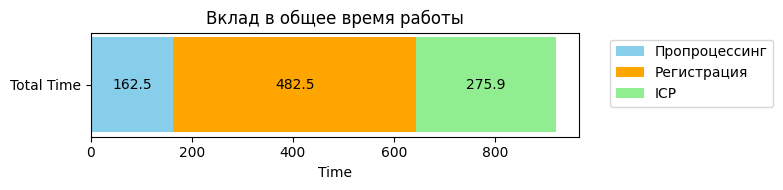

In [35]:
mean_times = [np.mean(preprocess_time) * 1000, np.mean(registration_time) * 1000, np.mean(transform_time) * 1000]
labels = ['Пропроцессинг', 'Регистрация', 'ICP']

total_time = sum(mean_times)

plt.figure(figsize=(8, 2))
bar_height = 0.8

plt.barh(['Total Time'], [mean_times[0]], height=bar_height, label=labels[0], color='skyblue')
plt.barh(['Total Time'], [mean_times[1]], height=bar_height, left=[mean_times[0]], label=labels[1], color='orange')
plt.barh(['Total Time'], [mean_times[2]], height=bar_height, left=[mean_times[0] + mean_times[1]], label=labels[2], color='lightgreen')

for i, time in enumerate(mean_times):
    x_position = sum(mean_times[:i]) + time / 2
    plt.text(x_position, 0, f'{time:.1f}', ha='center', va='center', color='black', fontsize=10)

plt.xlabel('Time')
plt.title('Вклад в общее время работы')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Среднее время работы ICP составило около 600мс, что примерно в 6 раз превышает время 1 тика лидара.

Это не позволит использовать данный алгоритм в текущем виде на реальных роботах, но как бейзлайн, от которого впоследствии можно будет отталкиваться подойдёт

In [36]:
threshold = 0.7  # изначально тут стояло 0.6, но в ТЗ указано 0.7

print('Number of correct matches with IoU > 0.5:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(len(ious)) if ious[i] > 0.5]))
print('Number of correct matches with IoU > 0.25:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(len(ious)) if ious[i] > 0.25]))
print('Number of wrong matches:', np.sum([(fitness > threshold) * (max(error) > 0.5) \
                                              for fitness, error in icp_results]))
print('Number of missed matches with IoU > 0.5:', np.sum([(icp_results[i][0] < threshold) * (ious[i] > 0.5) \
                                                          for i in range(len(ious))]))
print('Number of missed matches with IoU > 0.25:', np.sum([(icp_results[i][0] < threshold) * (ious[i] > 0.25) \
                                                          for i in range(len(ious))]))

Number of correct matches with IoU > 0.5: 259
Number of correct matches with IoU > 0.25: 272
Number of wrong matches: 321
Number of missed matches with IoU > 0.5: 307
Number of missed matches with IoU > 0.25: 3898


In [37]:
threshold = 0.7  # изначально тут стояло 0.6, но в ТЗ указано 0.7

print('Number of correct matches with IoU > 0.5:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(len(ious)) if ious[i] > 0.5]))
print('Number of correct matches with IoU > 0.25:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(len(ious)) if ious[i] > 0.25]))
print('Number of wrong matches:', np.sum([(fitness > threshold) * (max(error) > 0.5) \
                                              for fitness, error in icp_results]))
print('Number of missed matches with IoU > 0.5:', np.sum([(icp_results[i][0] < threshold) * (ious[i] > 0.5) \
                                                          for i in range(len(ious))]))
print('Number of missed matches with IoU > 0.25:', np.sum([(icp_results[i][0] < threshold) * (ious[i] > 0.25) \
                                                          for i in range(len(ious))]))

Number of correct matches with IoU > 0.5: 259
Number of correct matches with IoU > 0.25: 272
Number of wrong matches: 321
Number of missed matches with IoU > 0.5: 307
Number of missed matches with IoU > 0.25: 3898


In [38]:
threshold = 0.7
print('Precision:', np.sum([(fitness > threshold) * (max(error) < 0.5) \
                                              for fitness, error in icp_results]) / \
                    np.sum([(fitness > threshold) for fitness, error in icp_results]))
print('Recall with IoU > 0.5:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(len(ious)) if ious[i] > 0.5]) / \
                                sum([i > 0.5 for i in ious]))
print('Recall with IoU > 0.25:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(len(ious)) if ious[i] > 0.25]) / \
                                sum([i > 0.25 for i in ious]))

Precision: 0.45868465430016864
Recall with IoU > 0.5: 0.32094175960346966
Recall with IoU > 0.25: 0.06061956763984845


In [39]:
threshold = 0.7
print('Precision:', np.sum([(fitness > threshold) * (max(error) < 0.5) \
                                              for fitness, error in icp_results]) / \
                    np.sum([(fitness > threshold) for fitness, error in icp_results]))
print('Recall with IoU > 0.5:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(len(ious)) if ious[i] > 0.5]) / \
                                sum([i > 0.5 for i in ious]))
print('Recall with IoU > 0.25:', np.sum([(icp_results[i][0] > threshold) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(len(ious)) if ious[i] > 0.25]) / \
                                sum([i > 0.25 for i in ious]))

Precision: 0.45868465430016864
Recall with IoU > 0.5: 0.32094175960346966
Recall with IoU > 0.25: 0.06061956763984845


In [40]:
def get_iou_interval_indexes(lower_bound, upper_bound):
    return [i for i in range(len(ious)) if lower_bound <= ious[i] <= upper_bound]

In [41]:
icp_results_maxed = []

for fitness, error in icp_results:
    icp_results_maxed.append([fitness, max(error)])

icp_results_maxed = np.array(icp_results_maxed)
icp_results_maxed.shape

(8025, 2)

In [42]:
intervals = [
    [0.1, 0.2], [0.2, 0.3], [0.3, 0.4], [0.4, 0.5], [0.5, 0.6],
    [0.6, 0.7], [0.7, 0.8], [0.8, 0.9], [0.9, 1.0],
]

process_times = []
precision_values = []
threshold = 0.7

for lower_bound, upper_bound in intervals:
    suitable_indices = get_iou_interval_indexes(lower_bound, upper_bound)

    process_times.append(round(np.mean(np.array(icp_times)[suitable_indices]) * 1000))

    if np.sum([(fitness > threshold) for fitness, error in icp_results_maxed[suitable_indices]]) == 0:
        precision = 0
    else:
        precision = np.sum([(fitness > threshold) * (error < 0.5) \
                                                for fitness, error in icp_results_maxed[suitable_indices]]) / np.sum([(fitness > threshold) for fitness, error in icp_results_maxed[suitable_indices]])

    precision_values.append(precision)


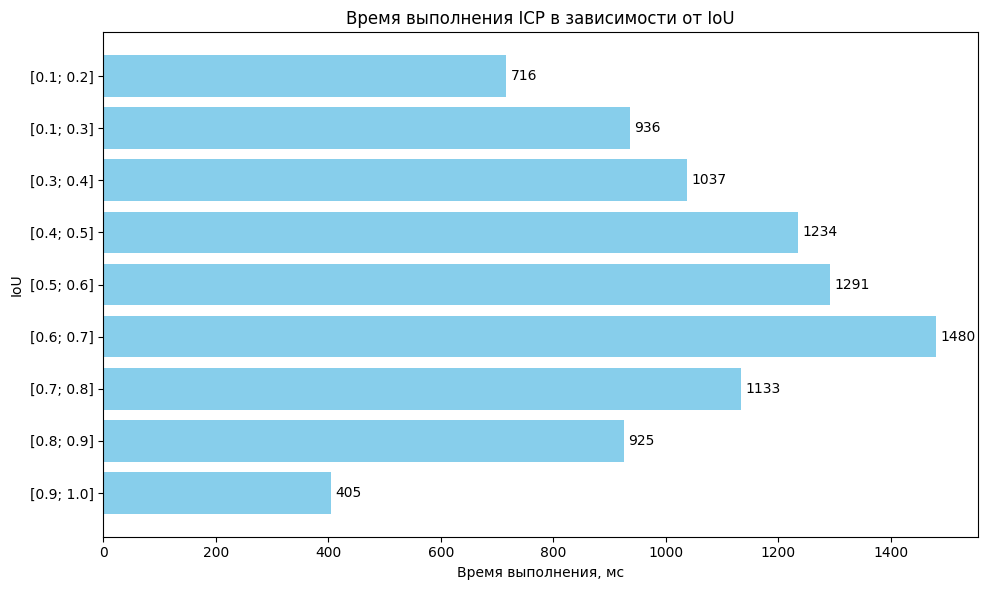

In [43]:
iou_intervals = ['[0.1; 0.2]', '[0.1; 0.3]', '[0.3; 0.4]', '[0.4; 0.5]', 
              '[0.5; 0.6]', '[0.6; 0.7]', '[0.7; 0.8]', '[0.8; 0.9]', '[0.9; 1.0]']

sorted_indices = [i for i in range(len(iou_intervals))]
intervals_sorted = [iou_intervals[i] for i in sorted_indices]
process_times_sorted = [process_times[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(intervals_sorted, process_times_sorted, color='skyblue')
plt.xlabel('Время выполнения, мс')
plt.ylabel('IoU')
plt.title('Время выполнения ICP в зависимости от IoU')

for i, v in enumerate(process_times_sorted):
    plt.text(v + 8, i, f"{v:.0f}", va='center')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


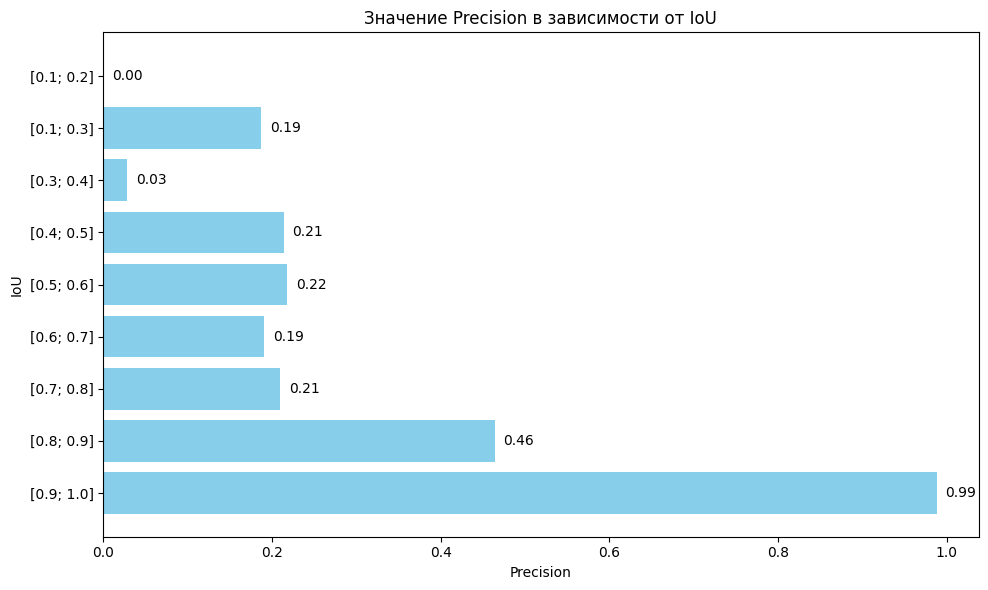

In [44]:
iou_intervals = ['[0.1; 0.2]', '[0.1; 0.3]', '[0.3; 0.4]', '[0.4; 0.5]', 
              '[0.5; 0.6]', '[0.6; 0.7]', '[0.7; 0.8]', '[0.8; 0.9]', '[0.9; 1.0]']

sorted_indices = [i for i in range(len(iou_intervals))]
intervals_sorted = [iou_intervals[i] for i in sorted_indices]
precision_values_sorted = [precision_values[i] for i in sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(intervals_sorted, precision_values_sorted, color='skyblue')
plt.xlabel('Precision')
plt.ylabel('IoU')
plt.title('Значение Precision в зависимости от IoU')

for i, v in enumerate(precision_values_sorted):
    plt.text(v + 0.01, i, f"{v:.2f}", va='center')

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Делать какие-то выводы об успешности модели я не могу - опыта в подобных задачах у меня не было, насмотренность на показатели метрик ещё не выработалась( Но я доволен, что решение работает, показывает какие-никакие, но результаты

Проблему скорости можно попробовать решить использованием C++, потому что хоть я по максимуму использую функции из библиотек, но есть подозрение, что это может помочь

# Подбор гиперпараметров

### Voxel Size

Основным гиперпараметром, который я подбирал был voxel_size. Требовалось найти(пока что на глаз), размер, который бы сохранял достаточно информации, но при этом бы сокращал время обработки

In [3]:
import copy

In [26]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.paint_uniform_color([1, 0.706, 0])
    target_temp.paint_uniform_color([0, 0.651, 0.929])
    source_temp.transform(transformation)
    o3d.visualization.draw_plotly([source_temp, target_temp], width=800, height=600)

In [6]:
dataset_dir = './data'
pr_data_dir = os.path.join(dataset_dir, 'place_recognition_data')
graph_data_dir = os.path.join(dataset_dir, 'graph_data')

In [7]:
sample_dir = os.listdir(pr_data_dir)[0]

test_dir = os.path.join(pr_data_dir, sample_dir)
transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))

cand_clouds = {}
cand_poses = {}

with np.load(os.path.join(test_dir, 'cloud.npz')) as CloudFile:
    ref_cloud = CloudFile['arr_0']

ref_cloud = ref_cloud[:, :3]
ref_cloud = ref_cloud[ref_cloud == ref_cloud].reshape((-1, 3))

for idx in transforms_[:, 0]:
    cloud = np.load(os.path.join(graph_data_dir, str(int(idx)), 'cloud.npz'))['arr_0']
    pose_stamped = np.loadtxt(os.path.join(graph_data_dir, str(int(idx)), 'pose_stamped.txt'))
    cand_clouds[int(idx)] = cloud
    cand_poses[int(idx)] = pose_stamped[1:]

In [11]:
cloud = cand_clouds[list(cand_clouds.keys())[0]]

In [22]:
source = make_pcd_from_array(cloud[:, :3])
target = make_pcd_from_array(ref_cloud)

Если не убирать графики из отображения, то размер блокнота увеличивается до 60Мб. При желании можно запустить клетки с импортом библиотек и объявлением вспомогательных функций, чтобы заново отобразить графики. В целях демонстрации прикрепляю изображения

In [ ]:
draw_registration_result(source, target, np.identity(4))

Изначальные облака точек

![](https://i.ibb.co/Vpg95jq/base-cloud.png)

In [ ]:
voxel_size = 0.05

source_down = make_pcd_from_array(cloud[:, :3]).voxel_down_sample(voxel_size=voxel_size)
target_down = make_pcd_from_array(ref_cloud).voxel_down_sample(voxel_size=voxel_size)

draw_registration_result(source_down, target_down, np.identity(4))

Облака точек при `voxel_size=0.05`

![](https://i.ibb.co/S3fhz7L/cloud-05.png)

In [ ]:
voxel_size = 0.1

source_down = make_pcd_from_array(cloud[:, :3]).voxel_down_sample(voxel_size=voxel_size)
target_down = make_pcd_from_array(ref_cloud).voxel_down_sample(voxel_size=voxel_size)

draw_registration_result(source_down, target_down, np.identity(4))

Облака точек при `voxel_size=0.1`

![](https://i.ibb.co/pbmSQcr/cloud-1.png)

In [ ]:
voxel_size = 0.2

source_down = make_pcd_from_array(cloud[:, :3]).voxel_down_sample(voxel_size=voxel_size)
target_down = make_pcd_from_array(ref_cloud).voxel_down_sample(voxel_size=voxel_size)

draw_registration_result(source_down, target_down, np.identity(4))

Облака точек при `voxel_size=0.2`

![](https://i.ibb.co/NZD7Nkh/cloud-2.png)

In [ ]:
voxel_size = 0.5

source_down = make_pcd_from_array(cloud[:, :3]).voxel_down_sample(voxel_size=voxel_size)
target_down = make_pcd_from_array(ref_cloud).voxel_down_sample(voxel_size=voxel_size)

draw_registration_result(source_down, target_down, np.identity(4))

Облака точек при `voxel_size=0.5`

![](https://i.ibb.co/z2FqpxQ/cloud-5.png)

В итоге я решил оставиться на voxel_size = 0.2. При этом значении сохраняется достаточное количество точек и время вычисления не выходит за рамки разумного

### Сравнение скорости и качества RANSAC и Fast global registration

В библиотеке Open3d представлено 2 основных алгоритма для глобальной регистрации: RANSAC и Fast Global Registration. Второй алгоритм по описанию должен позволять оптимизировать первое приближение быстрее RANSAC и при этом не сильно терять в качестве

Для проверки я выбрал 100 случайных сэмплов и запустил на оба 2 алгоритма.

In [45]:
ransac_fitness = []
fast_fitness = []

ransac_times = []
fast_times = []

ransac_errors = []
fast_errors = []

In [43]:
import random

random.seed(42)
random_dirs = os.listdir(pr_data_dir)
random.shuffle(random_dirs)

In [ ]:
for ii, test_name in tqdm(list(enumerate(random_dirs[:100]))):
    test_dir = os.path.join(pr_data_dir, test_name)
    try:
        transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
    except FileNotFoundError:
        continue

    if transforms_.size == 0:
        continue
    if transforms_.ndim == 1:
        transforms_ = transforms_[np.newaxis, :]
    
    cand_clouds = {}
    cand_poses = {}

    # Reference cloud (from robot)
    with np.load(os.path.join(test_dir, 'cloud.npz')) as CloudFile:
        ref_cloud = CloudFile['arr_0']

    ref_cloud = ref_cloud[:, :3]
    ref_cloud = ref_cloud[ref_cloud == ref_cloud].reshape((-1, 3))
    
    if transforms_.size == 0:
        continue
    
    for idx in transforms_[:, 0]:
        cloud = np.load(os.path.join(graph_data_dir, str(int(idx)), 'cloud.npz'))['arr_0']
        pose_stamped = np.loadtxt(os.path.join(graph_data_dir, str(int(idx)), 'pose_stamped.txt'))
        cand_clouds[int(idx)] = cloud
        cand_poses[int(idx)] = pose_stamped[1:]
    
    gt_poses = np.loadtxt(os.path.join(test_dir, 'gt_poses.txt'))
    ref_cloud = ref_cloud[ref_cloud == ref_cloud].reshape((-1, 3))
    
    for i in range(transforms_.size // 7):
        idx = transforms_[i, 0]
        gt_pose = cand_poses[int(idx)]
        pose_shift = get_rel_pose(*gt_poses[0], *gt_pose)

        # Candidate cloud (from graph of locations)
        cloud = cand_clouds[idx][:, :3]
        cloud = cloud[cloud == cloud].reshape((-1, 3))


        ransac_voxel_size = 0.2
        fast_voxel_size = 0.2  # [0.15, 0.25]

        # ICP
        # RANSAC GLOBAL REGISTRATION
        start_time = time.time()
        ransac_global_registration = get_global_registration(ref_cloud, cloud, voxel_size=ransac_voxel_size, algorithm='ransac')
        ransac_initial_transform = ransac_global_registration.transformation
        tf_ransac_matrix_icp, fitness_ransac_icp = transform_icp(ref_cloud, cloud, ransac_initial_transform)
        ransac_times.append(time.time() - start_time)

        error_ransac_icp = transformation_error(pose_shift, np.linalg.inv(tf_ransac_matrix_icp))
        
        ransac_fitness.append(fitness_ransac_icp)
        ransac_errors.append(error_ransac_icp)
        
        # FAST GLOBAL REGISTRATION
        start_time = time.time()
        fast_global_registration = get_global_registration(ref_cloud, cloud, voxel_size=fast_voxel_size, algorithm='fast')
        fast_initial_transform = fast_global_registration.transformation
        tf_fast_matrix_icp, fitness_fast_icp = transform_icp(ref_cloud, cloud, fast_initial_transform)
        fast_times.append(time.time() - start_time)

        error_fast_icp = transformation_error(pose_shift, np.linalg.inv(tf_fast_matrix_icp))
        
        fast_fitness.append(fitness_fast_icp)
        fast_errors.append(error_fast_icp)

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_8317/2606516879.py:4: UserWarning: loadtxt: input contained no data: "./data/place_recognition_data/1710505116224765000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
/tmp/ipykernel_8317/2606516879.py:4: UserWarning: loadtxt: input contained no data: "./data/place_recognition_data/1710495413820100000/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))


In [ ]:
np.save('results/ransac_fitness.npy', np.array(ransac_fitness))
np.save('results/fast_fitness.npy', np.array(fast_fitness))

np.save('results/ransac_times.npy', np.array(ransac_times))
np.save('results/fast_times.npy', np.array(fast_times))

np.save('results/ransac_errors.npy', np.array(ransac_errors))
np.save('results/fast_errors.npy', np.array(fast_errors))

In [48]:
import pandas as pd

In [56]:
pd.DataFrame({
    'RANSAC fitness':np.array(ransac_fitness),
    'FAST fitness': np.array(fast_fitness),
    'RANSAC times':np.array(ransac_times),
    'FAST times': np.array(fast_times),
    'RANSAC errors': np.array([np.max(row) for row in ransac_errors]),
    'FAST errors': np.array([max(row) for row in fast_errors]),
    }).describe()

,RANSAC fitness,FAST fitness,RANSAC times,FAST times,RANSAC errors,FAST errors
count,485.000000,485.000000,485.000000,485.000000,4.850000e+02,4.850000e+02
mean,0.306485,0.259724,0.690037,0.588260,7.067933e+00,6.819491e+00
std,0.253180,0.266060,0.243405,0.227760,4.724435e+00,4.600473e+00
min,0.020458,0.012033,0.241237,0.209621,2.948426e-09,6.236649e-09
25%,0.122318,0.079846,0.494844,0.408611,3.189762e+00,3.189762e+00
50%,0.197496,0.134022,0.650617,0.539859,6.402243e+00,6.184674e+00
75%,0.414545,0.385208,0.847996,0.741651,1.006002e+01,9.594741e+00
max,1.000000,1.000000,1.370953,1.323295,2.422411e+01,2.359514e+01


Первый запуск я проводил с одинаковым `voxel_size=0.2` 

Как можно заметить, **RANSAC** имеет качество на 45% лучше, чем **FAST**, если смотреть на медианное значение *fitness*. При этом время работы **RANSAC** больше всего на 20%

In [ ]:
# Разные FAST with voxel_size = 0.15
pd.DataFrame({
    'FAST fitness': np.array(fast_fitness),
    'FAST times': np.array(fast_times),
    'FAST errors': np.array([max(row) for row in fast_errors]),
    }).describe()

,FAST fitness,FAST times,FAST errors
count,485.000000,485.000000,4.850000e+02
mean,0.258596,0.770057,6.847999e+00
std,0.266641,0.321157,4.569177e+00
min,0.010053,0.219617,4.313446e-09
25%,0.077184,0.518332,3.189762e+00
50%,0.131853,0.697077,6.476144e+00
75%,0.376687,0.965717,9.977284e+00
max,1.000000,1.687535,2.311532e+01


Второй запуск я произвёл с `voxel_size=0.15` у алгоритма **FAST**.

Я надеялся улучшить его качество, не сильно потеряв в скорости. К сожалению, мне не удалось достичь такого результата. Показатели времени сравнялись с **RANSAC** `voxel_size=0.2`, а качество осталось практически идентичным предыдущему запуску **FAST**.

In [49]:
# Разные FAST with voxel_size = 0.25
pd.DataFrame({
    'FAST fitness': np.array(fast_fitness),
    'FAST times': np.array(fast_times),
    'FAST errors': np.array([max(row) for row in fast_errors]),
    }).describe()

,FAST fitness,FAST times,FAST errors
count,485.000000,485.000000,4.850000e+02
mean,0.256080,0.506057,6.927971e+00
std,0.265554,0.177137,4.677864e+00
min,0.009420,0.174025,3.612739e-09
25%,0.076805,0.363095,3.181746e+00
50%,0.128896,0.470661,6.376979e+00
75%,0.365875,0.627157,1.007903e+01
max,1.000000,1.011291,2.437363e+01


На третьем запуске я решил проверить противоположную гипотезу - что если увеличить voxel_size для алгоритма FAST и выиграть за счёт прироста скорости.

При `voxel_size=0.25` выигрыш в скорости составил 38%, а потеря в качестве fitness более - 50%. Увы, но эксперимент с алгоритмом FAST не удался. Возможно помог бы тюнинг ещё каких-то параметров помимо `voxel_size`